<a href="https://colab.research.google.com/github/Hilbert-HN/HN_ML_From_Scratch/blob/main/01_TensorFlow_Exercises/03_IMDB_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**03-IMDB Sentiment**

https://www.tensorflow.org/tutorials/keras/text_classification

# **Step 0 - Import Dependencies**

In [ ]:
import matplotlib.pyplot as plt

#handling directory
import os
import shutil

#handling pattern and text
import re
# https://docs.python.org/3/library/re.html
import string
# https://docs.python.org/3/library/string.html

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

In [ ]:
print (tf.__version__)

2.8.2


# **Step 1 - Load Dataset**

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84140032/84125825 [==============================] - 6s 0us/step


In [ ]:
os.listdir(dataset_dir)

['imdbEr.txt', 'test', 'train', 'README', 'imdb.vocab']

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['pos',
 'neg',
 'unsup',
 'labeledBow.feat',
 'urls_unsup.txt',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt']

# **Step 2 - Preprocessing the dataset**

In [ ]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [ ]:
# Remove unwanted files in directory
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

## **Split Data into Train / Validate / Test**

In [ ]:
# using text_dataset_from_directory within keras-utilities to assest the text data stored in directory
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/text_dataset_from_directory

# main_directory/
# ...class_a/
# ......a_text_1.txt
# ......a_text_2.txt
# ...class_b/
# ......b_text_1.txt
# ......b_text_2.txt


# it will create data-label numpy pairs into batch
# label of class_a and class_b be will be converted as label 0 and label 1

In [ ]:
batch_size = 32
seed = 42 

print('Training Data:')
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'training',
    seed = seed
)

print('\nValidation Data:')
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'validation',
    seed = seed
)

print('\nTesting Data:')
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size = batch_size
)


Training Data:
Found 25000 files belonging to 2 classes.
Using 20000 files for training.

Validation Data:
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.

Testing Data:
Found 25000 files belonging to 2 classes.


In [ ]:
# Above tensorflow directory data can be asset by tf.data.Dataset
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset

# print the first few elements in batch 1
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print('Review', text_batch.numpy()[i])
    print('Label', label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [ ]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


## **Define custom standardization and Strip HTML**

In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [ ]:
legal_chars = string.ascii_lowercase + string.digits + "!#$%&'*+-.^_`|~:"
print(legal_chars)
print('[%s]' % legal_chars)
print('[%s]' % re.escape(legal_chars))

print(string.punctuation)
print('[%s]' % re.escape(string.punctuation))

abcdefghijklmnopqrstuvwxyz0123456789!#$%&'*+-.^_`|~:
[abcdefghijklmnopqrstuvwxyz0123456789!#$%&'*+-.^_`|~:]
[abcdefghijklmnopqrstuvwxyz0123456789!\#\$%\&'\*\+\-\.\^_`\|\~:]
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
[!"\#\$%\&'\(\)\*\+,\-\./:;<=>\?@\[\\\]\^_`\{\|\}\~]


## **Define Layer for standardize the text and converting text to number token**

In [ ]:
# Using TextVectorization Layer
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = sequence_length
)

In [ ]:
# Make a text-only dataset (without labels), then call adapt
# During adapt(), the layer will build a vocabulary of all string tokens seen in the dataset
# sorted by occurance count, with ties broken by sort order of the tokens (high to low)


# input x, y, return x only 
# train_text = map(lambda x, y: x, raw_train_ds)
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)


In [ ]:
# insert a dimension of length 1, at position -1
# [10,10,3] --> [10,10,3,1]
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

## **View the tokenized result**

In [ ]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("\nVectorized review", vectorize_text(first_review, first_label))
print("\nVectorized review", vectorize_layer(first_review))

Review tf.Tensor(b'"A young woman suffers from the delusion that she is a werewolf, based upon a family legend of an ancestor accused of and killed for allegedly being one. Due to her past treatment by men, she travels the countryside seducing and killing the men she meets. Falling in love with a kind man, her life appears to take a turn for the better when she is raped and her lover is killed by a band of thugs. Traumatized again by these latest events, the woman returns to her violent ways and seeks revenge on the thugs," according to the DVD sleeve\'s synopsis.<br /><br />Rino Di Silvestro\'s "La lupa mannara" begins with full frontal, writhing, moaning dance by shapely blonde Annik Borel, who (as Daniella Neseri) mistakenly believes she is a werewolf. The hottest part is when the camera catches background fire between her legs. The opening "flashback" reveals her hairy ancestor was (probably) a lycanthropic creature. Ms. Borel is, unfortunately, not a werewolf; she is merely a very

In [ ]:
# view the vocabulary represented by the intget token
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


## **Map the token to all the dataset**

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

## **Better Data Peformance Setting**

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **Step 3 - Build the machine learning model**

**Embedding** 

This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. 
https://www.tensorflow.org/text/guide/word_embeddings

**GlobalAveragePooling1D** 

layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

In [ ]:
embedding_dim = 16

In [ ]:
model = tf.keras.Sequential([
             layers.Embedding(max_features+ 1, embedding_dim),
             layers.Dropout(0.2),
             layers.GlobalAveragePooling1D(),
             layers.Dropout(0.2),
             layers.Dense(1)                
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

# **Step 4 - Compile Model with optimizer, loss, metrics**

In [ ]:
model.compile(optimizer='adam',
              loss=losses.BinaryCrossentropy(from_logits=True),
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

#Threshold (Optional) Float representing the threshold for deciding whether prediction values are 1 or 0.

# **Step 5-Train the model**

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    epochs = epochs,
    validation_data = val_ds
)

Epoch 1/10
625/625 [==============================] - 13s 19ms/step - loss: 0.6622 - binary_accuracy: 0.6975 - val_loss: 0.6136 - val_binary_accuracy: 0.7726
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.5485 - binary_accuracy: 0.8007 - val_loss: 0.4990 - val_binary_accuracy: 0.8216
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4461 - binary_accuracy: 0.8451 - val_loss: 0.4212 - val_binary_accuracy: 0.8468
Epoch 4/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3791 - binary_accuracy: 0.8645 - val_loss: 0.3746 - val_binary_accuracy: 0.8614
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3362 - binary_accuracy: 0.8790 - val_loss: 0.3458 - val_binary_accuracy: 0.8664
Epoch 6/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3051 - binary_accuracy: 0.8885 - val_loss: 0.3264 - val_binary_accuracy: 0.8716
Epoch 7/10
625/625 [==============================] - 5s 8ms/s

# **Step 6 - Evaluate the model & Visualize the loss and accuracy**

In [ ]:
model.evaluate(test_ds, verbose=2)

782/782 - 7s - loss: 0.3100 - binary_accuracy: 0.8740 - 7s/epoch - 9ms/step


[0.31003624200820923, 0.8740400075912476]

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

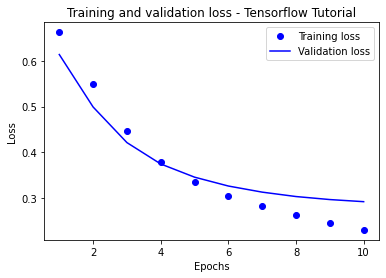

In [ ]:
loss_values= history_dict ['loss']
val_loss_values = history_dict ['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title("Training and validation loss - Tensorflow Tutorial")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

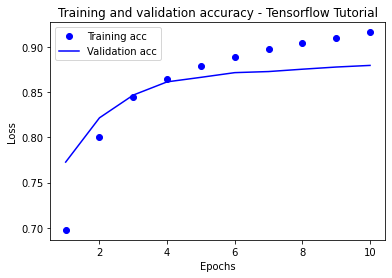

In [ ]:
plt.clf()

acc = history_dict ['binary_accuracy']
val_acc = history_dict ['val_binary_accuracy']

plt.plot(epochs, acc , 'bo', label = 'Training acc')
plt.plot(epochs, val_acc , 'b', label = 'Validation acc')
plt.title("Training and validation accuracy - Tensorflow Tutorial")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# **Step 7 - Export the model**

To include **Vectorization Layer** before model layers

To include **Activation Layer** after model layers

In [ ]:
export_model = tf.keras.Sequential([
                                    vectorize_layer,
                                    model,
                                    layers.Activation('sigmoid')
])

In [ ]:
export_model.compile(optimizer='adam',
              loss=losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Test it with `raw_test_ds`, which yields raw strings
export_model.evaluate(raw_test_ds, verbose=2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


782/782 - 8s - loss: 0.3100 - accuracy: 0.8740 - 8s/epoch - 10ms/step


[0.31003642082214355, 0.8740400075912476]

# **Step 8 - Prediction**

In [ ]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible...",
  "It is suck, terrible and boring"
]

export_model.predict(examples)

array([[0.61251515],
       [0.434301  ],
       [0.35201383],
       [0.22422329]], dtype=float32)

In [ ]:
examples = ["Spider-Man: No Way Home is a phenomenal conclusion to the trilogy and Holland's best outing as Spidey yet. Starts off fun, safe and familiar and then becomes extremely emotional, satisfying and full of great callbacks. A love letter to all things Spider-Man.Tom Holland gives an incredible lead performance once again, reliably charming and likeable but with a lot more emotional heft this time around. Zendaya and Jacob Batalon both have perfect chemistry with Holland and are also incredible in their own ways.Benedict Cumberbatch reaffirms why he's such a good Doctor Strange with his excellent dry wit and gravitas. All the returning villains give strong performances but Willem Dafoe is definitely the standout performance with an unsettling and terrifying presence.Jon Watts' direction is superb, the action sequences are thrillingly acrobatic once again but refreshingly impactful this time around. There's a few homages to the styles of the previous iterations and some gorgeous imagery.It's also perfectly paced with none of its roughly 2hr 30 minute runtime feeling dull or overly long due to a strong momentum established early on. The CG is extremely impressive with only a few weak spots.The music by Michael Giacchino is fantastic, a nice balance of themes from the previous iterations and use of Holland's iconic motifs which are slightly altered in ways that work as well as a few new additions that are beautifully epic."]

export_model.predict(examples)

array([[0.999846]], dtype=float32)